#1. Import

In [ ]:
!pip install yahoo_fin
!pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 81 kB 3.9 MB/s 
     |████████████████████████████████| 83 kB 1.7 MB/s 
     |████████████████████████████████| 127 kB 34.9 MB/s 
     |████████████████████████████████| 112 kB 54.5 MB/s 
  Created wheel for fake-useragent: filename=fake_useragent-0.1.11-py3-none-any.whl size=13502 sha256=9c0d949c30b2c1fc9cb44ab48b04f286de8ca18ced86f1286dfe48a0355a3b9c
  Stored in directory: /root/.cache/pip/wheels/ed/f7/62/50ab6c9a0b5567267ab76a9daa9d06315704209b2c5d032031
  Created wheel for parse: filename=parse-1.19.0-py3-none-any.whl size=24591 sha256=ecd9edc8bbf9e5989ee608a1a1febf2f467c4d2c8c01261cdaea12b82c5908cb
  Stored in directory: /root/.cache/pip/wheels/9c/aa/cc/f2228050ccb40f22144b073f15a2c84f11204f29fc0dce028e
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6066 sha256=17b128162cff5ef909fae47127711caec57db3899e854f08e25b0

In [ ]:
import tensorflow as tf
import pandas as pd
from yahoo_fin import stock_info as si
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf
import math
from statsmodels.tsa.seasonal import seasonal_decompose
import jinja2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#2. Collect

In [ ]:
df = {}
df = si.get_data('NG=F')
df = pd.DataFrame(df)
df = df [['open', 'close', 'high', 'low']].round(3)
resampled_df = df.resample('1D').mean()
resampled_df.interpolate(method='linear', axis = 0, inplace= True, limit_direction='forward')
plt.show()

#3. Preliminary Analysis

In [ ]:
resampled_df.corr()

,open,close,high,low
open,1.000000,0.997650,0.998691,0.998891
close,0.997650,1.000000,0.998852,0.998904
high,0.998691,0.998852,1.000000,0.998250
low,0.998891,0.998904,0.998250,1.000000


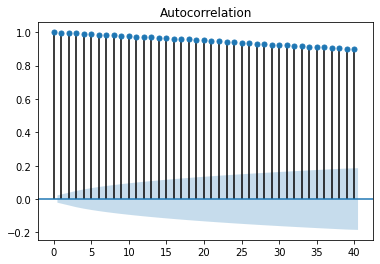

In [ ]:
stripped_resampled_df = resampled_df['close']
plot_acf(stripped_resampled_df)
plt.show()

In [ ]:
ma_resampled_df = pd.DataFrame(resampled_df['close'])
ma_resampled_df['ma180'] = resampled_df['close'].rolling(180).mean()
ma_resampled_df['ma60'] = resampled_df['close'].rolling(60).mean()
ma_resampled_df['ma30'] = resampled_df['close'].rolling(30).mean()
ma_resampled_df['std_min'] = resampled_df['close'] - resampled_df['close'].rolling(300).std()
ma_resampled_df['std_max'] = resampled_df['close'] + resampled_df['close'].rolling(300).std()
ma_resampled_df['gradient'] = np.gradient(resampled_df['close'])


ma_resampled_df = ma_resampled_df[359:]
ma_resampled_df

,close,ma180,ma60,ma30,std_min,std_max,gradient
2001-08-24,2.706,4.160425,3.130125,3.106800,0.837314,4.574686,-0.079500
2001-08-25,2.652,4.147047,3.117708,3.090933,0.777572,4.526428,-0.054000
2001-08-26,2.598,4.132092,3.107508,3.071967,0.717634,4.478366,-0.054000
2001-08-27,2.544,4.117086,3.095325,3.049133,0.657446,4.430554,-0.089000
2001-08-28,2.420,4.101725,3.084058,3.020100,0.526455,4.313545,-0.102000
...,...,...,...,...,...,...,...
2022-08-08,7.589,6.686700,7.214692,7.755211,5.973409,9.204591,0.042833
2022-08-09,7.833,6.708222,7.197742,7.806467,6.213394,9.452606,0.306500
2022-08-10,8.202,6.731894,7.188281,7.865667,6.576738,9.827262,0.520500
2022-08-11,8.874,6.758830,7.191358,7.956033,7.239651,10.508349,0.283000


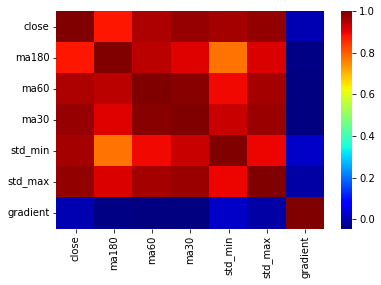

In [ ]:
import seaborn as sns

sns.heatmap(ma_resampled_df.corr(), cmap='jet')

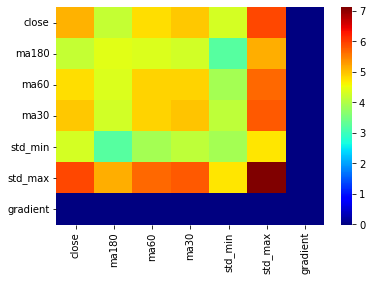

In [ ]:
sns.heatmap(ma_resampled_df.cov(), cmap='jet')

In [ ]:
ma_monthly_resampled_df = ma_resampled_df.resample('1M').mean()

In [ ]:
ma_monthly_resampled_df['close']

2001-08-31    2.504375
2001-09-30    2.285450
2001-10-31    2.621000
2001-11-30    2.803333
2001-12-31    2.715484
                ...   
2022-04-30    6.721633
2022-05-31    8.117871
2022-06-30    7.597100
2022-07-31    7.132629
2022-08-31    8.113333
Freq: M, Name: close, Length: 253, dtype: float64

#4. Data Augment

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [ ]:
monthly_resampled_df = ma_resampled_df.resample('1M').mean()

In [ ]:
def root(x):
  return math.sqrt(x)

In [ ]:
rows, attributes = monthly_resampled_df.shape

months = 72

scaler_mod = scaler.fit(monthly_resampled_df)
scaler_mean = list(map(np.float32, scaler.mean_))
scaler_var = list(map(np.float32,scaler.scale_))
print(list(map(np.float32, scaler_mean)))
print(list(map(np.float32, scaler_var)))
monthly_resampled_df_scaled = scaler.transform (monthly_resampled_df)
train_monthly_resampled_df = monthly_resampled_df_scaled[0:(rows-months)]
test_monthly_resampled_df = monthly_resampled_df_scaled[(rows-months):]

print(train_monthly_resampled_df.shape, test_monthly_resampled_df.shape) 


[4.525096, 4.4848275, 4.507883, 4.5159945, 3.75576, 5.294432, 0.0007294261]
[2.242612, 2.0974402, 2.201074, 2.2237859, 1.954213, 2.6469302, 0.02801084]
(181, 7) (72, 7)


In [ ]:
# for rowIndex, row in enumerate(monthly_resampled_df):
#   print(row)
#   break

In [ ]:
def batch_gen(df, x_size=24, y_size=24):
  X = []
  Y = []
  for i in range(x_size, df.shape[0]-y_size):
    X.append(df[i-x_size:i])
    Y.append([x[0] for x in df[i:i+y_size]])

  Y = np.array(Y)
  X = np.array(X)
  return X ,Y


batch_X_monthly_df_train, batch_Y_monthly_df_train = batch_gen(train_monthly_resampled_df)


print(f'Shape of Training Data: {batch_X_monthly_df_train.shape}')
print(f'Shape of Testing Data: {batch_Y_monthly_df_train.shape}')

Shape of Training Data: (133, 24, 7)
Shape of Testing Data: (133, 24)


In [ ]:
batch_X_monthly_df_train[:45]

array([[[-0.90105688, -0.17953568, -0.64459626, ..., -1.60800777,
         -0.33965847, -1.72683333],
        [-0.99867743, -0.32133879, -0.75893489, ..., -1.7798966 ,
         -0.37817199, -0.22045963],
        [-0.84905279, -0.55573814, -0.93335295, ..., -1.55773623,
         -0.2886527 ,  1.2136866 ],
        ...,
        [ 0.62460325,  0.48306601,  0.44662155, ...,  0.49263041,
          0.69468424,  1.1313452 ],
        [ 0.62034986,  0.61166457,  0.61776918, ...,  0.53868183,
          0.65347737, -1.17678585],
        [ 0.23205264,  0.63370076,  0.56454598, ...,  0.16548505,
          0.27103662, -0.68016551]],

       [[-0.99867743, -0.32133879, -0.75893489, ..., -1.7798966 ,
         -0.37817199, -0.22045963],
        [-0.84905279, -0.55573814, -0.93335295, ..., -1.55773623,
         -0.2886527 ,  1.2136866 ],
        [-0.76774879, -0.69631726, -0.86864074, ..., -1.1690148 ,
         -0.43787378, -0.7408435 ],
        ...,
        [ 0.62034986,  0.61166457,  0.61776918, ...,  

#6. LSTM


In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from keras.layers import LeakyReLU
from keras import backend as K
from tensorflow import keras
import os

In [ ]:
def rmse(y_true, y_pred):
  return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [ ]:
models_folder = '/content/drive/MyDrive/Models'
model_version = len(os.listdir(models_folder)) + 1
model_version

22

## a. Model Compilation

In [ ]:
model = Sequential()

model.add(LSTM(70, activation=LeakyReLU(alpha=0.01), input_shape=(batch_X_monthly_df_train.shape[1], batch_X_monthly_df_train.shape[2]), return_sequences=True))

model.add(LSTM(50, activation=LeakyReLU(alpha=0.01), return_sequences=True))

model.add(LSTM(80, activation=LeakyReLU(alpha=0.01), return_sequences=False))
model.add(Dropout(0.20))
model.add(Dense(batch_Y_monthly_df_train.shape[1]))
model.compile(loss=rmse, optimizer= keras.optimizers.Adam(learning_rate=0.003))
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 24, 70)            21840     
                                                                 
 lstm_7 (LSTM)               (None, 24, 50)            24200     
                                                                 
 lstm_8 (LSTM)               (None, 80)                41920     
                                                                 
 dropout_2 (Dropout)         (None, 80)                0         
                                                                 
 dense_2 (Dense)             (None, 24)                1944      
                                                                 
Total params: 89,904
Trainable params: 89,904
Non-trainable params: 0
_________________________________________________________________


## b. Model Fitting

In [ ]:
history = model.fit(batch_X_monthly_df_train, batch_Y_monthly_df_train, epochs=50, batch_size = 32, validation_split=0.2 , verbose = 1, callbacks=[early_stopping])

Epoch 1/50
4/4 [==============================] - 5s 234ms/step - loss: 1.2778 - val_loss: 0.5618
Epoch 2/50
4/4 [==============================] - 0s 63ms/step - loss: 1.2046 - val_loss: 0.5818
Epoch 3/50
4/4 [==============================] - 0s 57ms/step - loss: 1.2086 - val_loss: 0.6370
Epoch 4/50
4/4 [==============================] - 0s 59ms/step - loss: 1.1646 - val_loss: 1.0418
Epoch 5/50
4/4 [==============================] - 0s 61ms/step - loss: 1.1485 - val_loss: 0.9220
Epoch 6/50
4/4 [==============================] - 0s 58ms/step - loss: 1.1575 - val_loss: 0.6508
Epoch 7/50
4/4 [==============================] - 0s 58ms/step - loss: 1.1625 - val_loss: 0.6403
Epoch 8/50
4/4 [==============================] - 0s 55ms/step - loss: 1.1446 - val_loss: 0.6596
Epoch 9/50
4/4 [==============================] - 0s 61ms/step - loss: 1.1149 - val_loss: 0.6832
Epoch 10/50
4/4 [==============================] - 0s 54ms/step - loss: 1.0816 - val_loss: 0.6771
Epoch 11/50
4/4 [===========

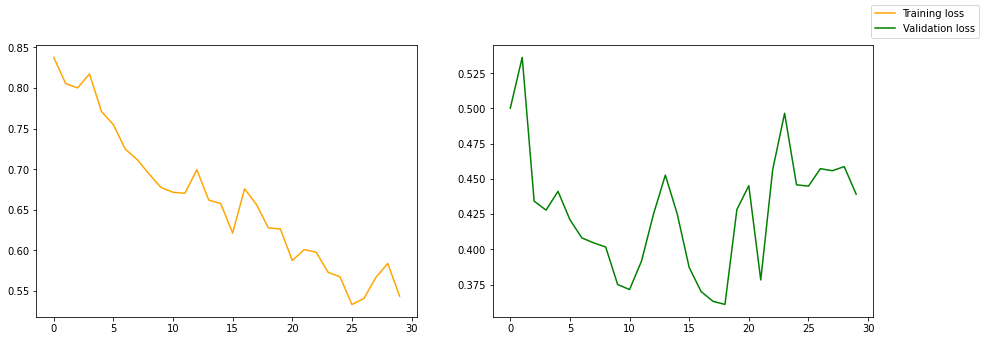

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=[15,5])
ax1.plot(history.history['loss'][20:], label='Training loss', c='orange')
ax2.plot(history.history['val_loss'][20:], label='Validation loss' , c = 'green')
fig.legend()
fig.show()

In [ ]:
batch_X_monthly_df_test, batch_Y_monthly_df_test  = batch_gen(test_monthly_resampled_df)
print(f'Shape of Testing Data: {batch_X_monthly_df_test.shape}')
print(f'Shape of Validating Data: {batch_Y_monthly_df_test.shape}')



Shape of Testing Data: (24, 24, 7)
Shape of Validating Data: (24, 24)


[[-0.41870195 -0.51059514 -0.59047174 -0.6260617  -0.46421927 -0.4481815
  -0.53088605 -0.32845262 -0.2981218  -0.3177957  -0.18252687 -0.26128083
  -0.05381021 -0.0884739  -0.1250124  -0.11696873 -0.14850503 -0.15964183
  -0.18048213 -0.14990515 -0.02088731  0.15517963  0.12518284  0.16789247]]


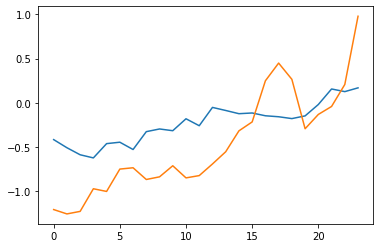

In [ ]:
index = 20
pred_data = batch_X_monthly_df_test[index]

result = []

res = model.predict(np.array([pred_data]))

print(res)
plt.plot(res[0])
plt.plot(batch_Y_monthly_df_test[index])
# for i in range(0, 36):
#   res = model.predict(np.array([pred_data]))[0,0]
#   res = (res * scaler_var[0]) + scaler_mean[0]
#   result.append(res)
#   pred_data = scaler.inverse_transform(pred_data)
#   res_30 = res
#   res_60 = sum([*pred_data[-2:,2] , res])/4
#   res_180 = sum([*pred_data[-5:,2] , res])/8
#   pred_data = list(pred_data)
#   pred_data.append(np.array([res, res_30, res_60, res_180]))
#   pred_data.pop(0)
#   pred_data = np.array(pred_data)
#   pred_data = scaler.transform(pred_data)

# print(result)

[]


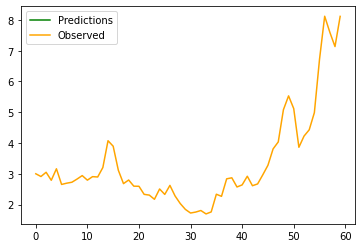

In [ ]:
test_monthly_resampled_df_unscaled = scaler.inverse_transform(test_monthly_resampled_df)
print(result[:])
plt.plot(result[:], label='Predictions', c='green')
plt.plot(test_monthly_resampled_df_unscaled[12:, 0], label='Observed' , c = 'orange')
plt.legend()
plt.show()

## c. Model Save

In [ ]:
save_model = str(input('Do you want to save model[y/n]: '))
if save_model.lower() != 'n':
  model.save(f'/content/drive/MyDrive/Models/Model_V{model_version}')



Do you want to save model[y/n]: n
